In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import string
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence
#from assnat.params import *
#from assnat.clean import complete_preproc
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Masking
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

from gensim.models import Word2Vec

from transformers import AutoTokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny", padding_side = "right")
tokenizer("My tokenizers and model must match")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'input_ids': [101, 2026, 19204, 17629, 2015, 1998, 2944, 2442, 2674, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [4]:
# $CHALLENGIFY_BEGIN
tokens = tokenizer("My model and my tokenizer must match")["input_ids"]

for x in tokens:
    print(f"{x} corresponds to {tokenizer.decode(x)}")
# $CHALLENGIFY_END

101 corresponds to [CLS]
2026 corresponds to my
2944 corresponds to model
1998 corresponds to and
2026 corresponds to my
19204 corresponds to token
17629 corresponds to ##izer
2442 corresponds to must
2674 corresponds to match
102 corresponds to [SEP]


In [5]:
# Chargement et prétraitement des données
leg_ = '/content/drive/MyDrive/Le Wagon/Project AssNat/leg16_preproc.csv'
min_words_=10

df_preproc = pd.read_csv(leg_)
#df_preproc = complete_preproc(df, na_col=["Texte", "famille"], drop_names=["Mme la présidente", "M. le président"], min_words=min_words_, punct_opt=True)
#df_preproc.to_csv('data/leg16_preproc.csv', index=False)

X = df_preproc['Texte']  # Les textes à classifier
y = df_preproc['famille']

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X.shape, len(y_encoded)

((131558,), 131558)

In [6]:
X[100]

'vous nous ressortez votre intention de plafonner la production d’énergie nucléaire à 50\xa0 comme si ce chiffre avait été gravé par moïse sur les tables de la loi alors que nous savons tous désormais qu’il a été griffonné sur un coin de table par françois hollande\xa0!'

In [7]:
# $CHALLENGIFY_BEGIN
tokenizer = AutoTokenizer.from_pretrained("almanach/camembert-base", padding_side = "right")

tokens = tokenizer(X[100])["input_ids"]

for x in tokens:
    print(f"{x} corresponds to {tokenizer.decode(x)}")
# $CHALLENGIFY_END

5 corresponds to <s>
39 corresponds to vous
63 corresponds to nous
4008 corresponds to ressort
267 corresponds to ez
75 corresponds to votre
7611 corresponds to intention
8 corresponds to de
8697 corresponds to pla
362 corresponds to f
11305 corresponds to onner
13 corresponds to la
844 corresponds to production
18 corresponds to d
12 corresponds to ’
1214 corresponds to énergie
4867 corresponds to nucléaire
15 corresponds to à
712 corresponds to 50
79 corresponds to comme
86 corresponds to si
44 corresponds to ce
2587 corresponds to chiffre
171 corresponds to avait
101 corresponds to été
16734 corresponds to gravé
37 corresponds to par
115 corresponds to m
8793 corresponds to oï
10 corresponds to s
35 corresponds to e
32 corresponds to sur
19 corresponds to les
5630 corresponds to tables
8 corresponds to de
13 corresponds to la
589 corresponds to loi
183 corresponds to alors
27 corresponds to que
63 corresponds to nous
6131 corresponds to savons
117 corresponds to tous
1085 correspond

In [8]:
# $CHALLENGIFY_BEGIN
from transformers import TFAutoModel
model = TFAutoModel.from_pretrained("almanach/camembert-base", from_pt = True)
# $CHALLENGIFY_END

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [9]:
model.num_parameters()

110621952

In [10]:
tensor_token = tokenizer(X[100], return_tensors="tf")
tensor_token

{'input_ids': <tf.Tensor: shape=(1, 63), dtype=int32, numpy=
array([[    5,    39,    63,  4008,   267,    75,  7611,     8,  8697,
          362, 11305,    13,   844,    18,    12,  1214,  4867,    15,
          712,    79,    86,    44,  2587,   171,   101, 16734,    37,
          115,  8793,    10,    35,    32,    19,  5630,     8,    13,
          589,   183,    27,    63,  6131,   117,  1085,    46,    12,
           62,    33,   101,    21, 21470,  9804,    32,    23,  1719,
            8,   847,    37,  9871, 14292, 13033, 10779,    83,     6]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 63), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int32)>}

<Axes: >

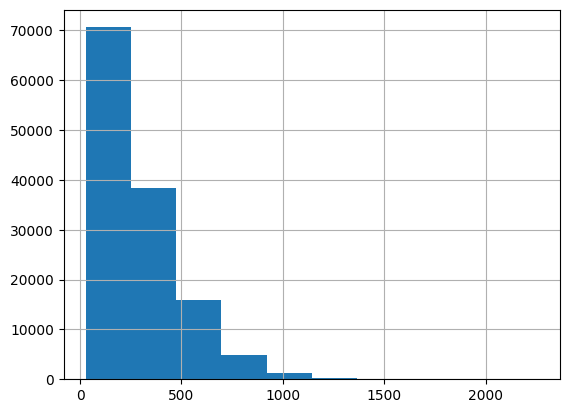

In [11]:
df_preproc["tokenized"] = X.map(lambda x: tokenizer(x)["input_ids"])

df_preproc["len_tokenized"] = X.map(lambda x: len(x))

df_preproc["len_tokenized"].hist()

In [12]:
sample_size = 50_000
# $CHALLENGIFY_BEGIN
tokenized_tensors = tokenizer(X[0:sample_size].tolist(), max_length=50, padding = "max_length", truncation = True, return_tensors="tf")
# $CHALLENGIFY_END

In [13]:
tokenized_tensors.input_ids.shape

TensorShape([50000, 50])

In [ ]:
#embeddings = model.predict(tokenized_tensors["input_ids"])

# Process the data in smaller batches
batch_size = 1000
embeddings = []
for i in range(0, sample_size, batch_size):
  batch_tensors = {k: v[i:i+batch_size] for k, v in tokenized_tensors.items()}
  batch_embeddings = model.predict(batch_tensors)
  embeddings.append(batch_embeddings)

# Concatenate the embeddings from all batches if necessary
#embeddings = np.concatenate(embeddings, axis=0)

 3/32 [=>............................] - ETA: 3s

In [16]:
embeddings[0:2]

[TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=array([[[ 0.0532216 ,  0.04991549,  0.11046399, ..., -0.10858352,
           0.03737131,  0.0110695 ],
         [ 0.07157509, -0.07916605,  0.19290379, ...,  0.04103548,
           0.03665832,  0.00314926],
         [ 0.01561674,  0.12426847,  0.09406845, ..., -0.12447979,
          -0.07138827,  0.07295826],
         ...,
         [ 0.123538  , -0.42362577,  0.11867409, ..., -0.01154631,
           0.041054  ,  0.05313954],
         [ 0.10628709,  0.37706298,  0.03471091, ..., -0.05813523,
           0.11697122,  0.08601236],
         [ 0.00896472,  0.08237377,  0.12580268, ..., -0.0777267 ,
          -0.00794687, -0.01098494]],
 
        [[ 0.05736858, -0.11006886,  0.07004154, ..., -0.07074974,
           0.00697316,  0.06330613],
         [-0.04866023,  0.28864402,  0.15088011, ...,  0.06994712,
           0.04030159,  0.10710827],
         [-0.07784601,  0.03689325, -0.01827769, ..., -0.02139296,
           0.051810

In [27]:
embeddings_all = np.concatenate([embeddings[x].last_hidden_state[:,0,:] for x in range(50)], axis=0)

In [28]:
embeddings_all.shape

(50000, 768)

In [29]:
#X_sample = embeddings.last_hidden_state[:,0,:]
X_sample = embeddings_all
y_sample = y_encoded[0:sample_size]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 768), (10000, 768), (40000,), (10000,))

In [31]:
# $CHALLENGIFY_BEGIN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

input_shape = (768,)

dense_model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(8, activation='softmax')
])

dense_model.summary()
# $CHALLENGIFY_END

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               196864    
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 198920 (777.03 KB)
Trainable params: 198920 (777.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
patience_ = 5
epoch_=100
early_stopper = EarlyStopping(monitor='val_loss', patience=patience_, restore_best_weights=True)

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

dense_model.fit(X_train, y_train, validation_split=0.2, epochs=epoch_, batch_size=32, callbacks=[early_stopper])

dense_model.evaluate(X_test, y_test)

Epoch 1/100
1000/1000 [==============================] - 6s 3ms/step - loss: 1.7675 - accuracy: 0.3333 - val_loss: 1.7547 - val_accuracy: 0.3325
Epoch 2/100
1000/1000 [==============================] - 4s 4ms/step - loss: 1.7259 - accuracy: 0.3422 - val_loss: 1.7219 - val_accuracy: 0.3392
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.7059 - accuracy: 0.3483 - val_loss: 1.7199 - val_accuracy: 0.3430
Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6941 - accuracy: 0.3542 - val_loss: 1.7068 - val_accuracy: 0.3462
Epoch 5/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6828 - accuracy: 0.3531 - val_loss: 1.7034 - val_accuracy: 0.3455
Epoch 6/100
1000/1000 [==============================] - 4s 4ms/step - loss: 1.6736 - accuracy: 0.3594 - val_loss: 1.7036 - val_accuracy: 0.3496
Epoch 7/100
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6655 - accuracy: 0.3610 - val_loss: 1.7061 - val_ac

[1.6902846097946167, 0.35910001397132874]

In [33]:
# Prédire sur l'ensemble de test
y_pred = dense_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher le rapport de classification
print("Rapport de classification pour le Dense avec Bert:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

313/313 [==============================] - 1s 2ms/step
Rapport de classification pour le Dense avec Bert:
                precision    recall  f1-score   support

        Centre       0.40      0.76      0.52      3191
  Centre-droit       0.33      0.01      0.01       835
 Centre-gauche       0.41      0.02      0.04       366
        Droite       0.29      0.04      0.07      1116
Extrême droite       0.28      0.10      0.15       972
Extrême gauche       0.33      0.36      0.34      1604
        Gauche       0.27      0.25      0.26      1791
      Variable       0.00      0.00      0.00       125

      accuracy                           0.36     10000
     macro avg       0.29      0.19      0.17     10000
  weighted avg       0.33      0.36      0.29     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Other structure

In [ ]:
# Construire le modèle RNN avec LSTM
#embedding_dim = embedding_dim_
input_shape = (768, 50)
patience_ = 5
epoch_=5

early_stopper = EarlyStopping(monitor='val_loss', patience=patience_, restore_best_weights=True)

model = Sequential()
#model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
#model.add(SpatialDropout1D(0.2))
model.add(Masking(input_shape=input_shape))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

# Compiler le modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher un résumé du modèle
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 768, 50)           0         
                                                                 
 dense_12 (Dense)            (None, 768, 256)          13056     
                                                                 
 dense_13 (Dense)            (None, 768, 8)            2056      
                                                                 
Total params: 15,112
Trainable params: 15,112
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Entraîner le modèle
batch_size = 64
epochs = epoch_

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopper],
    verbose=1
)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher le rapport de classification
print("Rapport de classification pour le Dense avec Bert:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

Epoch 1/5


ValueError: in user code:

    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_6" "                 f"(type Sequential).
    
    Input 0 of layer "dense_12" is incompatible with the layer: expected axis -1 of input shape to have value 50, but received input with shape (None, 1)
    
    Call arguments received by layer "sequential_6" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=True
      • mask=None
